In [429]:
# Librerías de datos y visualización
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import seaborn as sns

In [430]:
secciones = gpd.read_file('datos/secciones-electorales-pba.geojson')
secciones

,fid,fna,gna,nam,sag,seccion,geometry
0,1.0,Partido de Vicente López,Partido,Vicente López,IDEBA,I,"MULTIPOLYGON (((-58.523 -34.5976, -58.5231 -34..."
1,2.0,Partido de Rojas,Partido,Rojas,IDEBA,II,"MULTIPOLYGON (((-59.1967 -34.3737, -59.1967 -3..."
2,3.0,Partido de Magdalena,Partido,Magdalena,IDEBA,III,"MULTIPOLYGON (((-57.2767 -35.2257, -57.2766 -3..."
3,4.0,Partido de General Pinto,Partido,General Pinto,IDEBA,IV,"MULTIPOLYGON (((-61.2698 -36.0711, -61.2699 -3..."
4,5.0,Partido de General Lavalle,Partido,General Lavalle,IDEBA,V,"MULTIPOLYGON (((-59.3328 -38.7367, -59.3328 -3..."
5,6.0,Partido de Coronel Suárez,Partido,Coronel Suárez,IDEBA,VI,"MULTIPOLYGON (((-62.2489 -39.817, -62.2491 -39..."
6,7.0,Partido de Saladillo,Partido,Saladillo,IDEBA,VII,"MULTIPOLYGON (((-59.4882 -36.2271, -59.4881 -3..."
7,8.0,Partido de La Plata,Partido,La Plata,IDEBA,VIII,"MULTIPOLYGON (((-57.8082 -34.9621, -57.8038 -3..."


In [431]:
# Cantidad de bancas por sección
secciones_diputados = {
    "Capital": 6,
    "Segunda": 11,
    "Tercera": 18,
    "Sexta": 11    
}

secciones_senadores = {
    "Primera": 8,
    "Cuarta": 7,
    "Quinta": 5,
    "Séptima": 3
}

# Padrón real por sección (actualizado)
padron_real = {
    "Capital": 624845,
    "Primera": 4732831,
    "Segunda": 629021,
    "Tercera": 4845998,
    "Cuarta": 541541,
    "Quinta": 1310478,
    "Sexta": 663636,
    "Séptima": 282122
}

listas_politicas = [
    "Alianza La Libertad Avanza",  # PRO + LLA
    "Fuerza Patria",               # UxP
    "Somos Buenos Aires",          # UCR + PJ no K
    "Avanza Libertad",             # Libertarios - BLUE
    "FIT-U"                        # Izquierda
]

# # Sesgo Dirichlet según importancia política
# pesos_dirichlet = [5, 5, 3, 1.5, 0.2]

# Input: lista de porcentajes que suman 100
creencias = [35, 36, 15, 10, 4]  # por ejemplo, lo que cree un usuario

# Convertimos a pesos Dirichlet (normalizás con un "concentración" deseada)
concentracion = 100  # cuanto más grande, menos aleatorio
pesos_dirichlet = [p * concentracion / 100 for p in creencias]

# Parámetros de simulación
participacion = 0.60
votos_validos_pct = 0.90
# np.random.seed(42)

In [432]:
def simular_votos(padron_real, secciones_camara, listas, pesos_dirichlet, participacion, votos_validos_pct):
    data = []
    for seccion, cargos in secciones_camara.items():
        padron = padron_real[seccion]
        votos_emitidos = padron * participacion
        votos_validos = int(votos_emitidos * votos_validos_pct)

        proporciones = np.random.dirichlet(pesos_dirichlet)
        votos_listas = (proporciones * votos_validos).astype(int)

        for lista, votos in zip(listas, votos_listas):
            data.append({
                "seccion": seccion,
                "lista": lista,
                "votos": votos,
                "total_votos": votos_validos,
                "cargos": cargos
            })

    return pd.DataFrame(data)

# Simulamos ambas cámaras por separado
df_diputados = simular_votos(padron_real, secciones_diputados, listas_politicas, pesos_dirichlet, participacion, votos_validos_pct)
df_senadores = simular_votos(padron_real, secciones_senadores, listas_politicas, pesos_dirichlet, participacion, votos_validos_pct)


In [433]:
def repartir_bancas(df):
    resultados = []
    for seccion, grupo in df.groupby("seccion"):
        total_votos = grupo["votos"].sum()
        cargos = grupo["cargos"].iloc[0]
        cuociente = total_votos // cargos

        grupo = grupo.copy()
        grupo["enteros"] = grupo["votos"] // cuociente
        grupo["residuo"] = grupo["votos"] % cuociente
        grupo["bancas"] = grupo["enteros"]

        faltan = cargos - grupo["bancas"].sum()
        if faltan > 0:
            grupo = grupo.sort_values(["residuo", "votos"], ascending=False)
            grupo.iloc[:faltan, grupo.columns.get_loc("bancas")] += 1

        resultados.append(grupo[["seccion", "lista", "votos", "bancas"]])

    return pd.concat(resultados).reset_index(drop=True)

df_bancas_diputados = repartir_bancas(df_diputados)
df_bancas_senadores = repartir_bancas(df_senadores)



In [434]:
# DIPUTADOS
bancas_diputados = (
    df_bancas_diputados.groupby("lista")["bancas"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"lista": "Partido", "bancas": "Bancas en Diputados"})
)

# SENADORES
bancas_senadores = (
    df_bancas_senadores.groupby("lista")["bancas"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"lista": "Partido", "bancas": "Bancas en Senado"})
)

# Mostrar tablas
print("\n Bancas en Diputados:")
print(bancas_diputados.to_string(index=False))

print("\n Bancas en Senado:")
print(bancas_senadores.to_string(index=False))


 Bancas en Diputados:
                   Partido  Bancas en Diputados
             Fuerza Patria                   18
Alianza La Libertad Avanza                   15
        Somos Buenos Aires                    7
           Avanza Libertad                    4
                     FIT-U                    2

 Bancas en Senado:
                   Partido  Bancas en Senado
             Fuerza Patria                 9
Alianza La Libertad Avanza                 7
        Somos Buenos Aires                 5
           Avanza Libertad                 2
                     FIT-U                 0


In [435]:
ganadores_dip = (
    df_bancas_diputados.sort_values(["seccion", "bancas"], ascending=[True, False])
    .drop_duplicates("seccion")[["seccion", "lista"]]
    .rename(columns={"lista": "ganador_diputados"})
)

ganadores_sen = (
    df_bancas_senadores.sort_values(["seccion", "bancas"], ascending=[True, False])
    .drop_duplicates("seccion")[["seccion", "lista"]]
    .rename(columns={"lista": "ganador_senadores"})
)

In [436]:
# Mapeo de números romanos a nombres de sección
romanos_a_nombre = {
    "I": "Primera",
    "II": "Segunda",
    "III": "Tercera",
    "IV": "Cuarta",
    "V": "Quinta",
    "VI": "Sexta",
    "VII": "Séptima",
    "VIII": "Capital"
}

# Función de normalización
def normalizar(texto):
    return str(texto).strip().title()

# Aplicar mapeo y normalización al GeoDataFrame
secciones["seccion"] = secciones["seccion"].map(romanos_a_nombre)
secciones["seccion"] = secciones["seccion"].apply(normalizar)

# Normalizar también los DataFrames de bancas
df_bancas_diputados["seccion"] = df_bancas_diputados["seccion"].apply(normalizar)
df_bancas_senadores["seccion"] = df_bancas_senadores["seccion"].apply(normalizar)

# Crear nueva copia para trabajar visualización
secciones_resultado = secciones.copy()

# Merge con ganadores de cada cámara
secciones_resultado = secciones_resultado.merge(ganadores_dip, on="seccion", how="left")
secciones_resultado = secciones_resultado.merge(ganadores_sen, on="seccion", how="left")


In [437]:
print("Secciones no emparejadas en Diputados:")
print(set(df_bancas_diputados["seccion"]) - set(secciones["seccion"]))

print("Secciones no emparejadas en Senadores:")
print(set(df_bancas_senadores["seccion"]) - set(secciones["seccion"]))


Secciones no emparejadas en Diputados:
set()
Secciones no emparejadas en Senadores:
set()


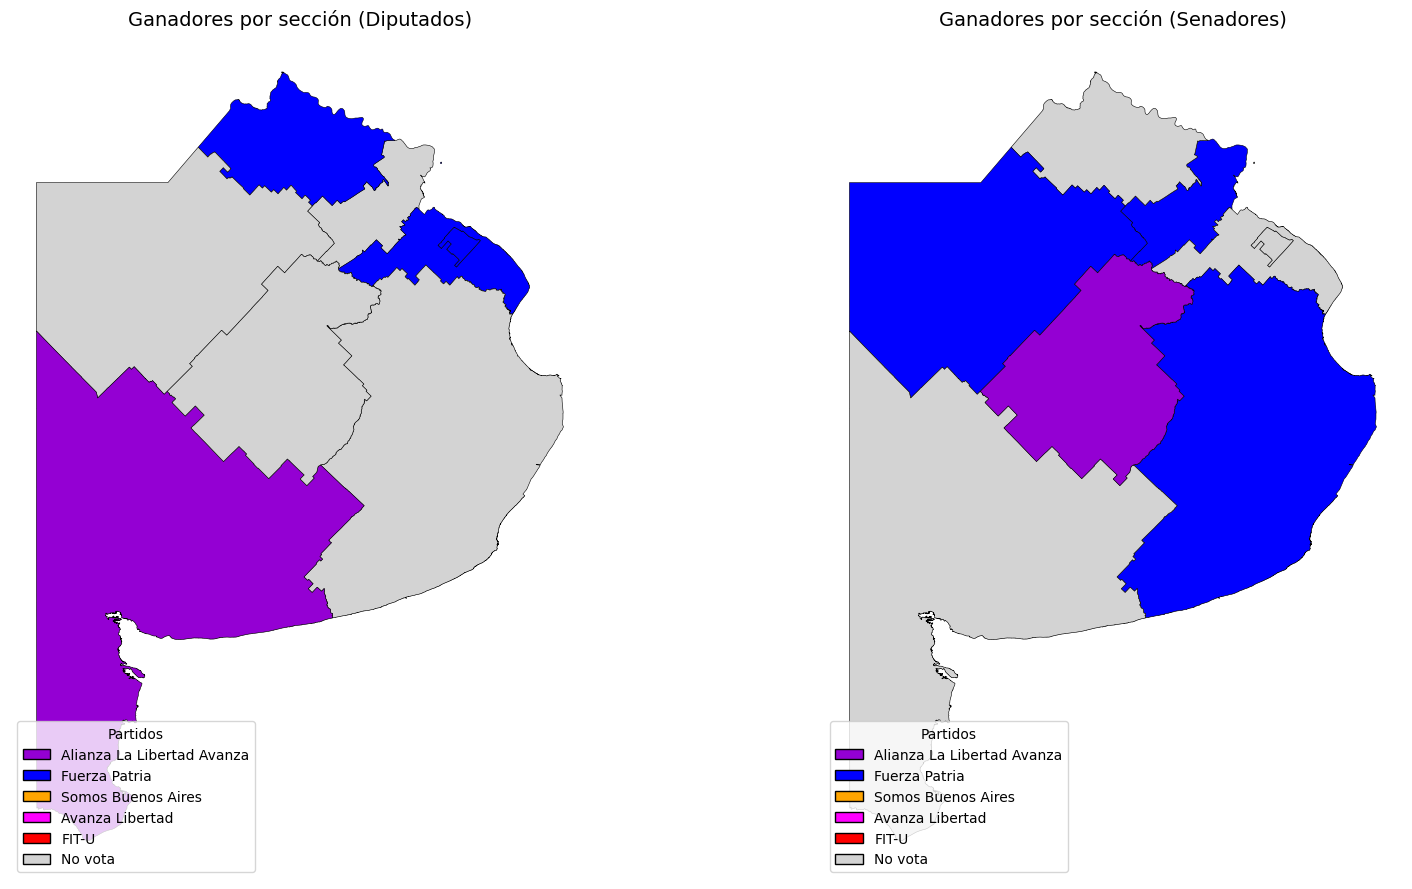

In [438]:
# Diccionario de colores
colores = {
    "Alianza La Libertad Avanza": "darkviolet",
    "Fuerza Patria": "blue",
    "Somos Buenos Aires": "orange",
    "Avanza Libertad": "magenta",
    "FIT-U": "red"
}

# Colores asignados por sección, con gris para NaN
color_diputados = secciones_resultado["ganador_diputados"].map(colores).fillna("lightgray")
color_senadores = secciones_resultado["ganador_senadores"].map(colores).fillna("lightgray")

# Leyenda común
legend_elements = [
    Patch(facecolor=colores[lista], edgecolor='black', label=lista)
    for lista in listas_politicas
]
legend_elements.append(Patch(facecolor="lightgray", edgecolor='black', label="No vota"))

# Crear figuras
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Diputados
secciones_resultado.plot(
    color=color_diputados,
    ax=axs[0],
    edgecolor="black",
    linewidth=0.4
)
axs[0].set_title("Ganadores por sección (Diputados)", fontsize=14)
axs[0].axis("off")
axs[0].legend(handles=legend_elements, loc='lower left', title="Partidos")

# Senadores
secciones_resultado.plot(
    color=color_senadores,
    ax=axs[1],
    edgecolor="black",
    linewidth=0.4
)
axs[1].set_title("Ganadores por sección (Senadores)", fontsize=14)
axs[1].axis("off")
axs[1].legend(handles=legend_elements, loc='lower left', title="Partidos")

plt.tight_layout()
plt.show()


In [439]:
secciones_resultado[["seccion", "ganador_diputados", "ganador_senadores"]]


,seccion,ganador_diputados,ganador_senadores
0,Primera,NaN,Fuerza Patria
1,Segunda,Fuerza Patria,NaN
2,Tercera,Fuerza Patria,NaN
3,Cuarta,NaN,Fuerza Patria
4,Quinta,NaN,Fuerza Patria
5,Sexta,Alianza La Libertad Avanza,NaN
6,Séptima,NaN,Alianza La Libertad Avanza
7,Capital,Fuerza Patria,NaN
